<a href="https://colab.research.google.com/github/pamela2412/recomendaciones_similares/blob/main/recomendaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# %% 1. Configuración inicial y descarga
!pip install -q kaggle tqdm tensorflow_hub annoy

from google.colab import files
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from annoy import AnnoyIndex
from tqdm.auto import tqdm

# Descargar dataset
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip -q food11-image-dataset.zip

# %% 2. Seleccionar categorías (¡Editar esta lista!)
CATEGORIAS_SELECCIONADAS = [
    'Bread',          # Pan
    'Meat',           # Carne
    'Seafood',        # Mariscos
    'Dessert'         # Postres
]

# %% 3. Crear dataframe filtrado
def crear_dataframe_filtrado(base_path, categories):
    data = []
    splits = ['training', 'validation']

    for split in splits:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue

        for category in categories:
            category_path = os.path.join(split_path, category)
            if not os.path.exists(category_path):
                print(f"⚠️ Categoría '{category}' no encontrada en {split}. Omitiendo...")
                continue

            for img_name in os.listdir(category_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data.append({
                        'split': split,
                        'category': category,
                        'path': os.path.join(category_path, img_name)
                    })

    return pd.DataFrame(data)

df_filtrado = crear_dataframe_filtrado('/content', CATEGORIAS_SELECCIONADAS)

print("\n📊 Dataset filtrado:")
print(f"Total imágenes: {len(df_filtrado)}")
print(df_filtrado['category'].value_counts())





Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset
License(s): CC0-1.0
100% 1.08G/1.08G [00:30<00:00, 36.4MB/s]
100% 1.08G/1.08G [00:30<00:00, 37.7MB/s]

📊 Dataset filtrado:
Total imágenes: 6332
category
Dessert    2000
Meat       1774
Bread      1356
Seafood    1202
Name: count, dtype: int64


In [5]:
# %% 4. Cargar modelo BiT-M
bit_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x3/1", trainable=False)

# Función de preprocesamiento optimizada
def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    return tf.keras.applications.imagenet_utils.preprocess_input(img)

# %% 5. Generar embeddings CORREGIDO
# --------------------------------------------------
# Generar embeddings y verificar dimensiones
embeddings = []
for batch in tqdm(dataset, desc="Generando embeddings"):
    batch_embeddings = bit_model(batch).numpy()

    # Aplanar los embeddings si es necesario
    if batch_embeddings.ndim == 3:  # Si la salida es (batch_size, 1, 2048)
        batch_embeddings = np.squeeze(batch_embeddings, axis=1)

    embeddings.append(batch_embeddings)

embeddings = np.vstack(embeddings)

# Verificar dimensión final
print("\n🔍 Dimensión de los embeddings:", embeddings.shape[1])

# %% 6. Configurar Annoy con la dimensión CORRECTA
# --------------------------------------------------
EMBEDDING_DIM = embeddings.shape[1]  # Usar la dimensión real

annoy_index = AnnoyIndex(EMBEDDING_DIM, 'angular')  # Dimension dinámica

for i, emb in enumerate(tqdm(embeddings, desc="Indexando")):
    annoy_index.add_item(i, emb)

annoy_index.build(n_trees=100)
annoy_index.save('food_index_filtered.ann')


Generando embeddings:   0%|          | 0/198 [00:00<?, ?it/s]


🔍 Dimensión de los embeddings: 6144


Indexando:   0%|          | 0/6332 [00:00<?, ?it/s]

True

In [6]:
# %% 7. Función de recomendación mejorada
def recomendar_comida(image_path, top_k=5):
    try:
        # Preprocesar y generar embedding
        img = preprocess_image(image_path)
        query_embedding = bit_model(tf.expand_dims(img, 0)).numpy().flatten()

        # Buscar similares y filtrar por categoría
        indices = annoy_index.get_nns_by_vector(query_embedding, top_k*2)  # Buffer
        resultados = df_filtrado.iloc[indices]

        # Eliminar duplicados de misma categoría
        resultados = resultados.drop_duplicates(subset=['category']).head(top_k)

        return resultados[['path', 'category']]

    except Exception as e:
        print(f"🚨 Error: {str(e)}")
        return None

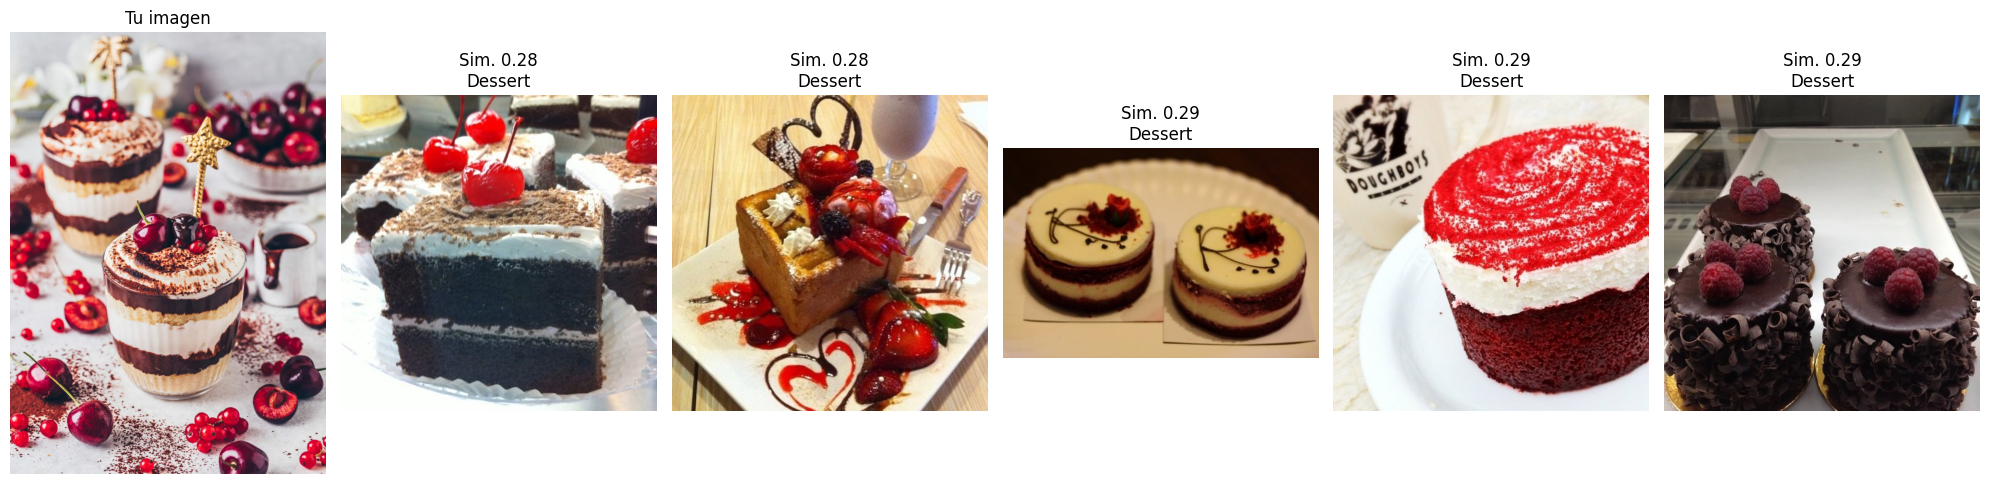

In [17]:
import numpy as np
import tensorflow as tf
from PIL import Image
from ipywidgets import FileUpload
from IPython.display import display, clear_output
import io
import matplotlib.pyplot as plt

# Función de preprocesamiento (¡idéntica al entrenamiento!)
def preprocess_image(path_or_bytes, from_bytes=False):
    if from_bytes:
        img = tf.image.decode_jpeg(path_or_bytes, channels=3)
    else:
        img = tf.io.read_file(path_or_bytes)
        img = tf.image.decode_jpeg(img, channels=3)

    img = tf.image.resize(img, (224, 224))
    return tf.keras.applications.imagenet_utils.preprocess_input(img)

# Función de recomendación
def recomendar_comida(query_embedding, top_k=5):
    # Buscar los índices más cercanos
    indices = annoy_index.get_nns_by_vector(query_embedding, top_k)

    # Obtener rutas de las imágenes recomendadas
    resultados = df_filtrado.iloc[indices].copy()

    # Calcular distancias de similitud
    resultados['similitud'] = [
        1 - (np.dot(query_embedding, embeddings[i]) /
            (np.linalg.norm(query_embedding) * np.linalg.norm(embeddings[i])))
        for i in indices
    ]

    return resultados

# Función para mostrar resultados
def mostrar_resultados(query_img, resultados):
    plt.figure(figsize=(20, 5))

    # Mostrar imagen consulta
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title("Tu imagen")
    plt.axis('off')

    # Mostrar recomendaciones
    for i, (_, row) in enumerate(resultados.iterrows(), 2):
        plt.subplot(1, 6, i)
        img = Image.open(row['path'])
        plt.imshow(img)
        plt.title(f"Sim. {row['similitud']:.2f}\n{row['category']}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Función interactiva
def handle_upload(change):
    clear_output()

    if uploader.value:
        try:
            # Obtener imagen subida
            uploaded = next(iter(uploader.value.values()))
            img_bytes = uploaded['content']

            # Procesamiento IDÉNTICO al dataset
            img_tensor = preprocess_image(img_bytes, from_bytes=True)
            query_embedding = bit_model(tf.expand_dims(img_tensor, 0)).numpy().flatten()

            # Generar recomendaciones
            resultados = recomendar_comida(query_embedding)

            # Mostrar resultados
            mostrar_resultados(Image.open(io.BytesIO(img_bytes)), resultados)

        except Exception as e:
            print(f"Error: {str(e)}")

# Widget interactivo
uploader = FileUpload(accept='image/*')
uploader.observe(handle_upload, names='value')
display(uploader)